In [1]:
import numpy as np
import scipy.io as sio
from sklearn import svm
from sklearn.model_selection import cross_val_score
from sklearn.metrics.pairwise import pairwise_distances
from sklearn import manifold
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.svm import SVC

In [2]:
from graph_kernels_lib import WeisfeilerLehmanKernel, fit_n_components

In [3]:
ppi = sio.loadmat("PPI.mat")
ppi_graphs = ppi['G'][0]
ppi_labels = ppi['labels'].ravel()

In [4]:
n = ppi_labels.shape[0]

In [5]:
wl_kernel = WeisfeilerLehmanKernel()

In [6]:
K = wl_kernel.eval_similarities(ppi_graphs[:]['am'], 2)

In [7]:
D = pairwise_distances(K, metric='euclidean')

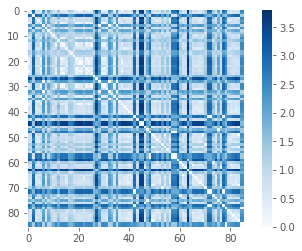

In [28]:
plt.imshow(D, zorder=2, cmap='Blues', interpolation='nearest')
plt.colorbar();
plt.style.use("ggplot")
plt.show()

# SVM Linear Classifier

In [9]:
from sklearn.model_selection import StratifiedKFold
strat_k_fold = StratifiedKFold(n_splits = 10, shuffle = True) #10

In [10]:
clf = svm.SVC(kernel="linear", C = 1.0)
scores_ln = cross_val_score(clf, D, ppi_labels, cv = strat_k_fold)
print(str(np.min(scores_ln)) +" - "+str(np.mean(scores_ln))+ " - " + str(np.max(scores_ln)) + " - "+ str(np.std(scores_ln)))

0.5555555555555556 - 0.763888888888889 - 1.0 - 0.15023130314433286


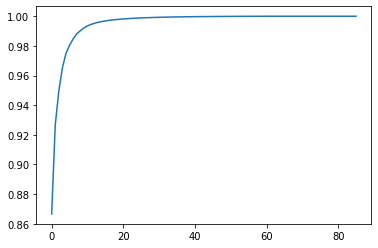

array([0.86662235, 0.92668825, 0.94954188])

In [11]:
PCA_D = PCA(n_components = 2).fit_transform(D)
plt.plot(np.cumsum(PCA().fit(D).explained_variance_ratio_))
plt.show()
np.cumsum(PCA().fit(D).explained_variance_ratio_)[:3]

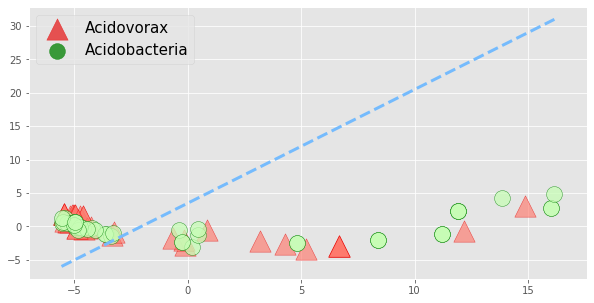

In [27]:
acidovorax = PCA_D[ppi_labels == 1]
acidobacteria = PCA_D[ppi_labels == 2]

clf = clf.fit(PCA_D, ppi_labels)
w = clf.coef_[0]
a = -w[0] / w[1]
xx = np.linspace(np.min(PCA_D), np.max(PCA_D))
yy = a * xx - (clf.intercept_[0]) / w[1]

plt.figure(figsize=(10,5))


ax_av = plt.scatter(acidovorax[:, 0], acidovorax[:, 1], color = "xkcd:red", marker = "^",label = "Acidovorax", s = 455, alpha = 0.65) 
ax_ab = plt.scatter(acidobacteria[:, 0], acidobacteria[:, 1], color = "green", label = "Acidobacteria",  s = 250, alpha = 0.75)
svm_line = plt.plot(xx, yy, color = "xkcd:sky blue", linestyle = "--", linewidth = 3.0)

plt.axis('tight');
#plt.grid(True)
plt.legend(prop={'size': 15})

ax_av.set_facecolor('xkcd:salmon')
ax_ab.set_facecolor('xkcd:pale green')

plt.show()


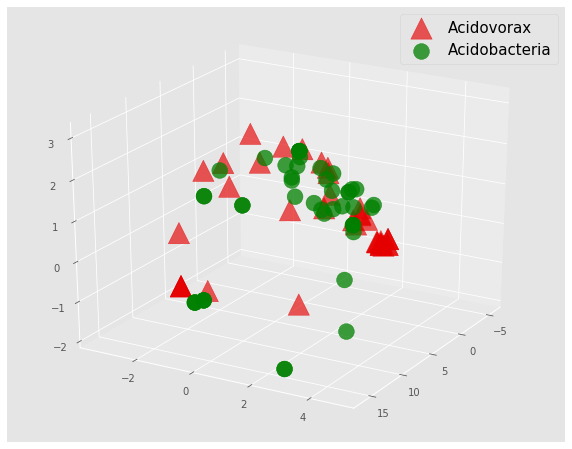

In [13]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111, projection='3d')

PCA_D = PCA(n_components = 3).fit_transform(D)

acidovorax = PCA_D[ppi_labels == 1]
acidobacteria = PCA_D[ppi_labels == 2]

clf = clf.fit(PCA_D, ppi_labels)
w = clf.coef_[0]
a = -w[0] / w[1]
xx = np.linspace(np.min(PCA_D), np.max(PCA_D))
yy = a * xx - (clf.intercept_[0]) / w[1]

#plt.figure(figsize=(10,5))


ax_av = ax.scatter(acidovorax[:, 0], acidovorax[:, 1], acidovorax[:, 2],c = "xkcd:red", marker = "^",label = "Acidovorax", s = 455, alpha = 0.65) 
ax_ab = ax.scatter(acidobacteria[:, 0], acidobacteria[:, 1], acidobacteria[:, 2], c = "green", label = "Acidobacteria",  s = 250, alpha = 0.75)
#svm_line = plt.plot(xx, yy, color = "xkcd:sky blue", linestyle = "--", linewidth = 3.0)

plt.axis('tight');
#plt.grid(True)
plt.legend(prop={'size': 15})

ax_av.set_facecolor('xkcd:salmon')
ax_ab.set_facecolor('xkcd:pale green')
ax.view_init(azim = 30, elev = 25)
plt.show()


# Manifold Learning Isomap

In [14]:
n_neighbors = 14#15
n_components = 2
iso_prj_D = manifold.Isomap(n_neighbors, n_components).fit_transform(D)

In [15]:
scores_ln = cross_val_score(clf, iso_prj_D, ppi_labels, cv = strat_k_fold, n_jobs= 8)
np.mean(scores_ln)

0.6944444444444444

It seems that manifold learning with Isomap does not improve the performance of our linear svm classifier

### Plots for Isomap

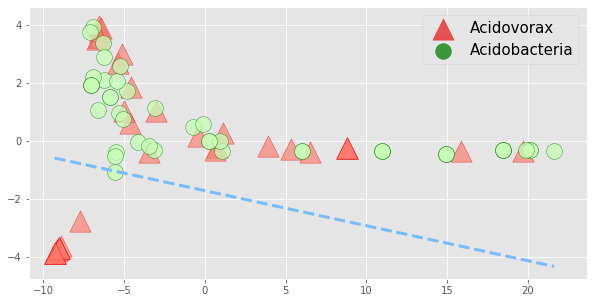

In [16]:
acidovorax = iso_prj_D[ppi_labels == 1]
acidobacteria = iso_prj_D[ppi_labels == 2]

clf = clf.fit(iso_prj_D, ppi_labels)
w = clf.coef_[0]
a = -w[0] / w[1]
xx = np.linspace(np.min(iso_prj_D), np.max(iso_prj_D))
yy = a * xx - (clf.intercept_[0]) / w[1]

plt.figure(figsize=(10,5))


ax_av = plt.scatter(acidovorax[:, 0], acidovorax[:, 1], color = "xkcd:red", marker = "^",label = "Acidovorax", s = 455, alpha = 0.65) 
ax_ab = plt.scatter(acidobacteria[:, 0], acidobacteria[:, 1], color = "green", label = "Acidobacteria",  s = 250, alpha = 0.75)
svm_line = plt.plot(xx, yy, color = "xkcd:sky blue", linestyle = "--", linewidth = 3.0)

plt.axis('tight');
#plt.grid(True)
plt.legend(prop={'size': 15})

ax_av.set_facecolor('xkcd:salmon')
ax_ab.set_facecolor('xkcd:pale green')

plt.show()


#### Fit with best n of components

In [17]:
opt_n_components = fit_n_components(D, ppi_labels, manifold.Isomap, n_iteration= 10)

In [18]:
opt_iso_prj_D = manifold.Isomap(n_neighbors, opt_n_components).fit_transform(D)

In [19]:
scores_ln = cross_val_score(clf, opt_iso_prj_D, ppi_labels, cv = strat_k_fold, n_jobs= 8)
np.mean(scores_ln)

0.7930555555555555

#  Manifold Learning LocalLinearEmbedding

In [20]:
n_neighbors = 13#15
n_components = 15
lle_prj_D = manifold.LocallyLinearEmbedding(n_neighbors, n_components).fit_transform(D)

In [21]:
scores_ln = cross_val_score(clf, lle_prj_D, ppi_labels, cv = strat_k_fold, n_jobs= 8)
np.mean(scores_ln)

0.7361111111111112

It seems that also manifold learning with LocalLinearEmbedding does not improve the performance of our linear svm classifier

### Plots for LLE

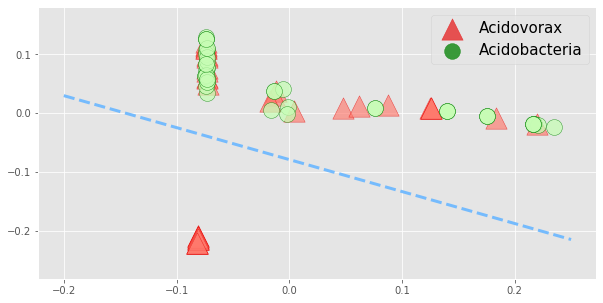

In [22]:
acidovorax = lle_prj_D[ppi_labels == 1]
acidobacteria = lle_prj_D[ppi_labels == 2]

clf = clf.fit(lle_prj_D, ppi_labels)
w = clf.coef_[0]
a = -w[0] / w[1]
xx = np.linspace(-0.2,0.25)
yy = a * xx - (clf.intercept_[0]) / w[1]
plt.figure(figsize=(10,5))


ax_av = plt.scatter(acidovorax[:, 0], acidovorax[:, 1], color = "xkcd:red", marker = "^",label = "Acidovorax", s = 455, alpha = 0.65) 
ax_ab = plt.scatter(acidobacteria[:, 0], acidobacteria[:, 1], color = "green", label = "Acidobacteria",  s = 250, alpha = 0.75)
svm_line = plt.plot(xx, yy, color = "xkcd:sky blue", linestyle = "--", linewidth = 3.0)

plt.axis('tight');
#plt.grid(True)
plt.legend(prop={'size': 15})

ax_av.set_facecolor('xkcd:salmon')
ax_ab.set_facecolor('xkcd:pale green')

plt.show()


#### Fit with best n of components

In [23]:
opt_n_components = fit_n_components(D, ppi_labels, manifold.LocallyLinearEmbedding, n_neighbors=13, n_iteration= 10)
opt_n_components

8

In [24]:
opt_lle_prj_D = manifold.LocallyLinearEmbedding(13, opt_n_components).fit_transform(D)

In [25]:
scores_ln = cross_val_score(clf, opt_lle_prj_D, ppi_labels, cv = strat_k_fold, n_jobs= 8)
np.mean(scores_ln)

0.7458333333333333

# Graphs plots

In [26]:
import networkx as nx

G = nx.from_numpy_matrix(ppi_graphs[10]['am'])
#pos=nx.spring_layout(G) # positions for all nodes
pos = nx.spring_layout(G, k = 0.9, iterations = 1000)
nx.draw_networkx_nodes(G, pos, with_labels= False, node_color = "green", node_size = 300, alpha = 0.8)
nx.draw_networkx_edges(G, pos, width = 2, alpha=0.5,edge_color='r')
plt.axis('off')
#plt.savefig("acidovorax_graph_10.png") # save as png
plt.show() # display

ModuleNotFoundError: No module named 'networkx'

In [ ]:
G = nx.from_numpy_matrix(ppi_graphs[59]['am'])
#pos=nx.spring_layout(G) # positions for all nodes
pos = nx.spring_layout(G, k = 0.9, iterations = 1000)
nx.draw_networkx_nodes(G, pos, with_labels= False, node_color = "green", node_size = 300, alpha = 0.8)
nx.draw_networkx_edges(G, pos, width = 2, alpha=0.5,edge_color='r')
plt.axis('off')
#plt.savefig("Acidobacteria_graph_59.png") # save as png
plt.show() # display

In [ ]:
G = nx.from_numpy_matrix(ppi_graphs[6]['am'])
#pos=nx.spring_layout(G) # positions for all nodes
pos = nx.spring_layout(G, k = 0.9, iterations = 1000)
nx.draw_networkx_nodes(G, pos, with_labels= False, node_color = "green", node_size = 300, alpha = 0.8)
nx.draw_networkx_edges(G, pos, width = 2, alpha=0.5,edge_color='r')
plt.axis('off')
#plt.savefig("acidovorax_graph_2.png") # save as png
plt.show() # display

In [ ]:
G = nx.from_numpy_matrix(ppi_graphs[48]['am'])
#pos=nx.spring_layout(G) # positions for all nodes
pos = nx.spring_layout(G, k = 0.9, iterations = 1000)
nx.draw_networkx_nodes(G, pos, with_labels= False, node_color = "green", node_size = 300, alpha = 0.8)
nx.draw_networkx_edges(G, pos, width = 2, alpha=0.5,edge_color='r')
plt.axis('off')
#plt.savefig("Acidobacteria_graph_48.png") # save as png
plt.show() # display

In [ ]:
node_labels = wl_kernel.extract_graphs_labels(ppi_graphs[:]['am'])
size = int(np.max(np.concatenate(node_labels)))
degree_component = np.zeros((n, size))
for i in range(len(node_labels)):
    for j in node_labels[i]:
        degree_component[i,int(j)-1] += 1
degree_component[0]
